<a href="https://colab.research.google.com/github/AbigailDerton/titanic-ml/blob/main/Titanic_Survival_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster

Author: Abigail Derton ([LinkedIn](https://www.linkedin.com/in/abigail-derton/), [GitHub](https://github.com/AbigailDerton))

This notebook is my submission to the classic [Titanic: Machine Learning from Disaster](https://www.kaggle.com/competitions/titanic) competition on Kaggle. Using models from the scikit-learn library, I compare several machine learning approaches to predict which passengers survived the Titanic shipwreck.

The workflow is organized as follows:

1. Import required libraries and load the data

2. Explore and visualize key features

3. Build a data-cleaning and preprocessing pipeline

4. Train and tune machine learning models to predict survival

5. Evaluate model performance on unseen test data

##1. Import required libraries and load the data

Load required libraries:

In [38]:
import os # used to check/change working directory
import pandas as pd # for reading/manipulating pandas dataframes
import numpy as np # for getting unique values in a column
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for data visualization
from pandas.plotting import scatter_matrix # for plotting every numerical attribute against every other numerical attribute

# Show plots inline:
%matplotlib inline

Load the data:

In [27]:
train_set = pd.read_csv("titanic_data/train.csv")
test_set = pd.read_csv("titanic_data/test.csv")

## 2. Explore and visualize key features

Look at first few rows of each dataframe and examine summary statistics:

In [28]:
print(train_set.head()) # look at the first few rows of data
print(train_set.info()) # look at data types and non-null counts
print(train_set.describe()) # statistical summaries of numerical columns
print(train_set.shape) # number of rows and columns

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

In [29]:
print(test_set.head()) # look at the first few rows of data
print(test_set.shape) # number of rows and columns

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  
(418, 11)


The training set includes 12 features and 891 rows. The features Age, Cabin, and Embarked contain some null values. Approximately 38.4% of passengers survived, indicating a reasonably balanced target variable. The features Name, Sex, Ticket, Cabin, and Embarked are text/categorical and will need to be converted to numeric format before fitting machine learning models.

The test set does not include labels (Survived).

Examine the distribution of numeric features. Make sure to code sex as numeric so it can be included in the plots:

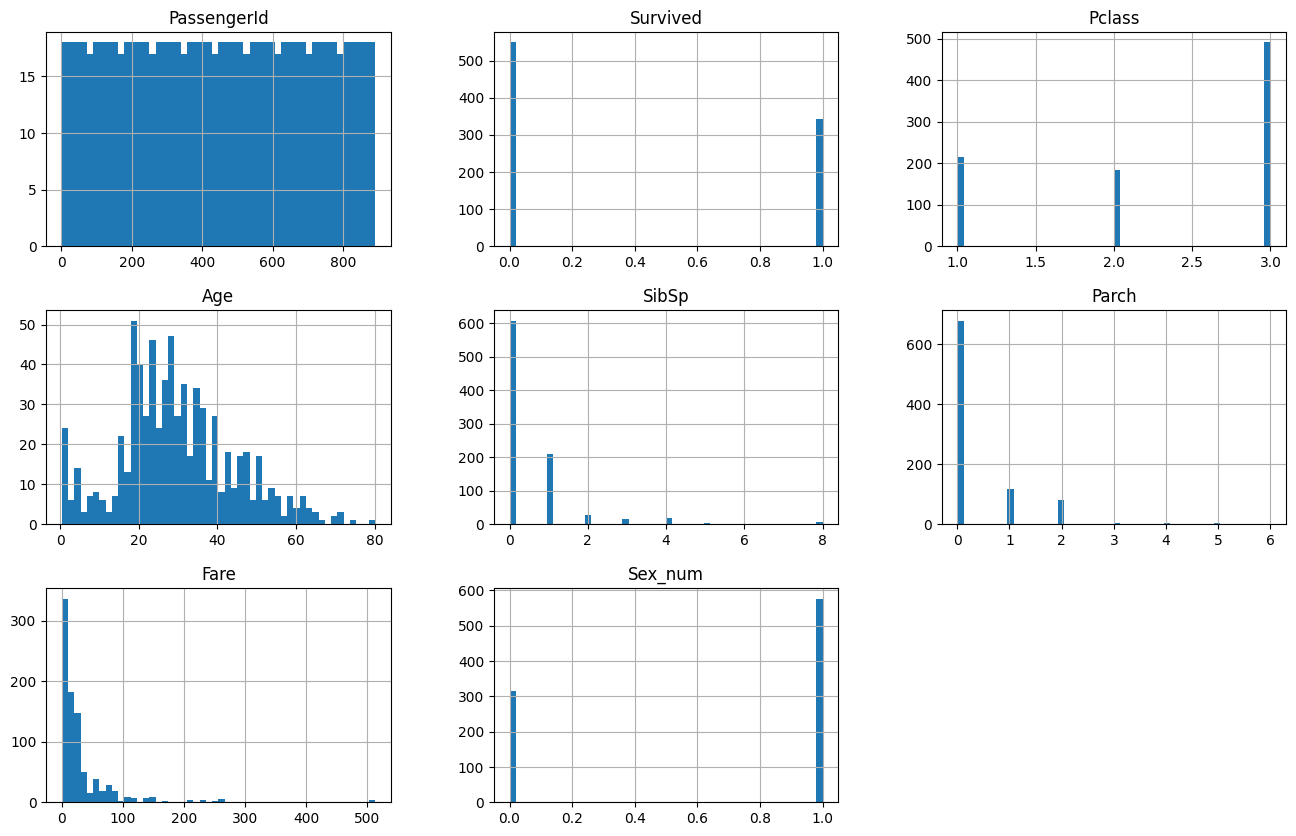

In [30]:
# create a numeric column for passenger sex
train_set["Sex_num"] = train_set["Sex"].map({"female":0, "male": 1})

# plot histograms of all numeric features
train_set.hist(bins=50, figsize=(16,10))
plt.show()

Examine the correlations between numeric features:

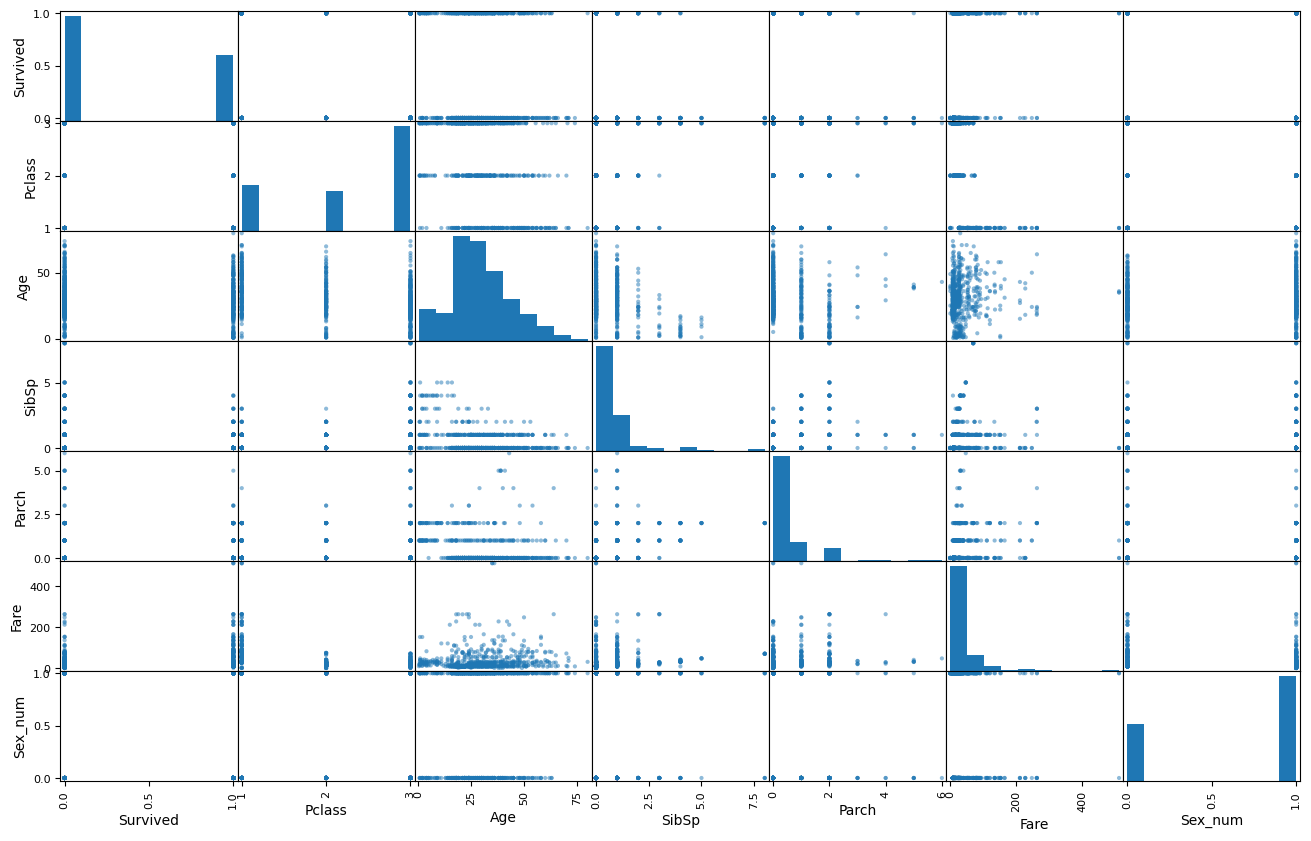

In [32]:
scatter_matrix(train_set[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_num"]], figsize=(16, 10))
plt.show()

The above scatter matrix did not reveal any strong correlations.

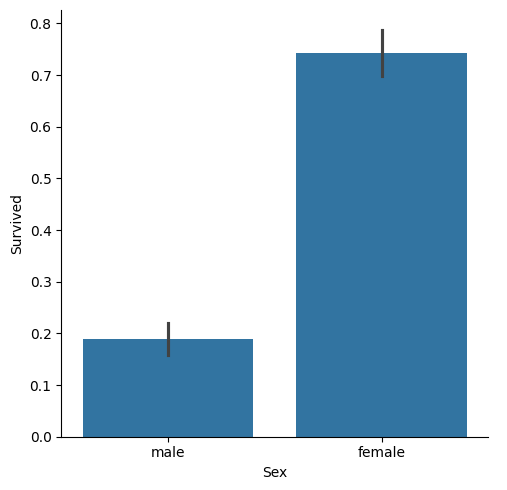

In [37]:
#sns.catplot(data=train_set, x="Sex", y="Survived", hue="Pclass", kind="bar")
sns.catplot(data=train_set, x="Sex", y="Survived", kind="bar")

## 3. Build a data-cleaning and preprocessing pipeline

Build a pipeline that performs the following transformations:



*   Create a numerical Sex feature
*   Impute missing passenger age

*   Impute missing port of embarkation
*   One-hot encode port of embarkation

*   Drop features not intended for use in machine learning model





